In [197]:
import numpy as np
import cv2
import glob
from pathlib import Path
import os
import matplotlib.pyplot as plt

In [198]:
# Setup SimpleBlobDetector parameters.
blobParams = cv2.SimpleBlobDetector_Params()

# Change thresholds
blobParams.minThreshold = 0
blobParams.maxThreshold = 255

# Filter by Area.
blobParams.filterByArea = True
blobParams.minArea = 50    # minArea may be adjusted to suit for your experiment
blobParams.maxArea = 2000   # maxArea may be adjusted to suit for your experiment

# Filter by Circularity
blobParams.filterByCircularity = True
blobParams.minCircularity = 0.1

# Filter by Convexity
blobParams.filterByConvexity = True
blobParams.minConvexity = 0.87

# Filter by Inertia
blobParams.filterByInertia = True
blobParams.minInertiaRatio = 0.01

# Create a detector with the parameters
blobDetector = cv2.SimpleBlobDetector_create(blobParams)

In [199]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
 
# path
path = "../from_nas/imgs"

images = []
for folder in os.listdir(path):
    tmp_path = os.path.join(path, folder, "*.png")
    print(f"{tmp_path = }")
    images.extend(glob.glob(tmp_path))

tmp_path = '../from_nas/imgs\\01.Image\\*.png'
tmp_path = '../from_nas/imgs\\02.Image\\*.png'
tmp_path = '../from_nas/imgs\\03.Image\\*.png'


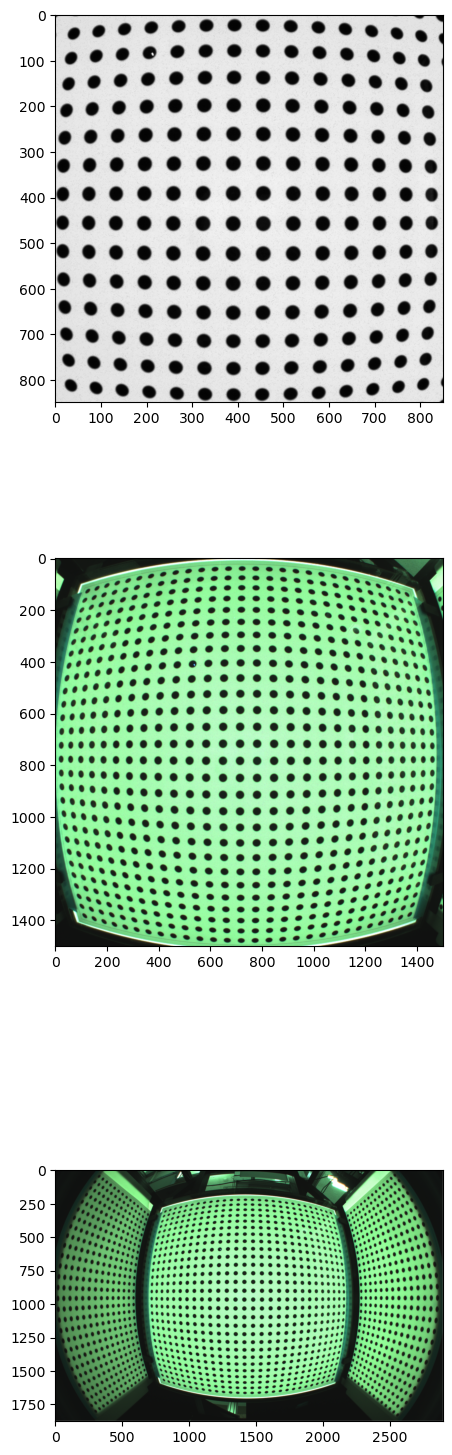

In [200]:
img = cv2.imread(images[0])
H, W = img.shape[:2]

imgs = []
pixels_to_shrink = 850
for pix in (pixels_to_shrink, 1500):
    H_start = (H - pix) // 2
    H_end = H_start + pix

    W_start = (W - pix) // 2
    W_end = W_start + pix
    # img = img[190:1690,700:2200] # just crop the center rectangle
    # img = img[690:1190, 1200:1700] # 8 : 8
    img_crop = img[H_start:H_end, W_start:W_end]
    imgs.append(img_crop)
# img = np.pad(img, ((H_start, H - H_end), (W_start, W - W_end), (0, 0)), 'constant', constant_values=255)
# assert img.shape[:2] == (H, W)
imgs.append(img)

pixel_pattern_map = dict()
pixel_pattern_map[500] = (8, 8)
pixel_pattern_map[650] = (10, 10)
pixel_pattern_map[750] = (12, 12)
pixel_pattern_map[850] = (14, 14)
pixel_pattern_map[900] = (14, 14)
pixel_pattern_map[980] = (16, 16)
pixel_pattern_map[1060] = (18, 18)
pixel_pattern_map[1500] = (28, 28)

gray = cv2.cvtColor(imgs[0], cv2.COLOR_BGR2GRAY)


fig, axes = plt.subplots(3, 1, figsize=(5, 20))
for i in range(len(axes)):
    if i == 0:
        axes[i].imshow(gray, cmap="gray")    
    elif i == 1:
        axes[i].imshow(imgs[1], cmap="gray")    
    else:
        axes[i].imshow(imgs[2], cmap="gray")    
# plt.imshow(gray, cmap="gray")
plt.show()

In [201]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

pattern_size = pixel_pattern_map[pixels_to_shrink]
print(f"{pattern_size = }")

objp = np.zeros((pattern_size[1]*pattern_size[0],3), np.float32)
objp[:,:2] = np.mgrid[0:pattern_size[0],0:pattern_size[1]].T.reshape(-1,2)

pattern_size = (14, 14)


In [202]:
ret, corners = cv2.findCirclesGrid(gray, pattern_size, None, cv2.CALIB_CB_SYMMETRIC_GRID | cv2.CALIB_CB_CLUSTERING, blobDetector)
# ret, corners = cv2.findCirclesGrid(gray, pattern_size, None, cv2.CALIB_CB_SYMMETRIC_GRID | cv2.CALIB_CB_CLUSTERING)
if ret:
    print(f"{ret = }, {corners.shape = }")
    objpoints.append(objp)
else:
    print("Not found")

ret = True, corners.shape = (196, 1, 2)


In [203]:
corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
imgpoints.append(corners2)
print(f"corners == corners2 in all? {(corners == corners2).all()}")

corners == corners2 in all? True


In [204]:
# # this draws the lines on the image permanently
# cv2.drawChessboardCorners(imgs[0], pattern_size, corners2, ret)
# cv2.imshow('img', imgs[0])
# cv2.waitKey(3000)

# cv2.destroyAllWindows()

In [205]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [210]:
# resizing
# mtx[0, -1] = mtx[0, -1] + (1500 - pixels_to_shrink)
# mtx[1, -1] = mtx[1, -1] + (1500 - pixels_to_shrink)
mtx[0, -1] = W / 2
mtx[1, -1] = H / 2
# print(f"{mtx = }")

h, w = imgs[2].shape[:2]

# note the order of size is width -> height, not height -> width
new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))


In [172]:
# test_mtx = [
#     [2670.12822326, 0, 1.48139826e+03],
#     [0, 1570.15941637, 9.13122290e+02],
#     [0, 0, 1]
# ]

# test_mtx = np.array(test_mtx)

In [173]:
# img_copy = imgs[0].copy()
# img_copy = cv2.resize(img_copy, (850*3, 850*3))

# plt.imshow(img_copy)
# plt.show()

In [212]:
# undistort
dst = cv2.undistort(imgs[2], mtx, dist, None, new_camera_mtx)

# crop the image
x, y, w, h = roi
dst2 = dst[y:y+h, x:x+w]


cv2.imwrite("original.png", imgs[2])
cv2.imwrite('calibresult.png', dst2)

True

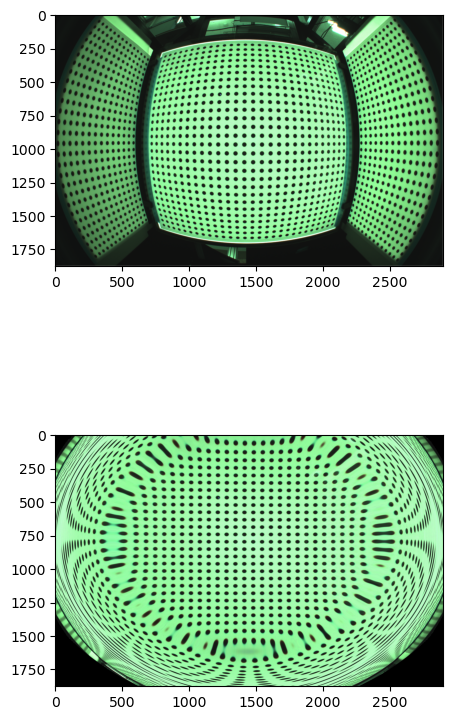

In [213]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))
axes[0].imshow(imgs[2])
axes[1].imshow(dst)
plt.show()

In [214]:
roi

(0, 0, 2895, 1548)

In [11]:
# save the matrix, if needed
np.savez("new_camera_mtx.npz", new_camera_mtx)

In [12]:
# Re-projection Error
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    mean_error += error

print(f"total error: {mean_error / len(objpoints)}")

total error: 81.49002773798638


In [ ]:
# for fname in images:
#     img = cv.imread(fname)
#     gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
 
#     # Find the chess board corners
#     ret, corners = cv.findChessboardCorners(gray, (7,6), None)
 
#     # If found, add object points, image points (after refining them)
#     if ret == True:
#     objpoints.append(objp)
 
#     corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
#     imgpoints.append(corners2)
 
#     # Draw and display the corners
#     cv.drawChessboardCorners(img, (7,6), corners2, ret)
#     cv.imshow('img', img)
#     cv.waitKey(500)
 
# cv.destroyAllWindows()